In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
import keras.backend as K

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [ ]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


# **Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  df_drop = df.drop(['label'], axis=1)
  names = df_drop.columns
  fit = scaler.fit_transform(df_drop)
  scaled_df = pd.DataFrame(fit, columns=names)
  df_new = pd.concat([df['label'],scaled_df], axis = 1)
  return df_new

# **Segmentation with window size 30 (without overlap)**

In [ ]:
eda_freq = 4
temp_freq = 4
hr_freq = 1
bvp_freq = 64
acc_freq = 32

#without overlap
def get_data(pid):

    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = pd.read_csv(output_path + eda_path)
    temp_data_raw = pd.read_csv(output_path + temp_path)
    bvp_data_raw = pd.read_csv(output_path + bvp_path)
    hr_data_raw = pd.read_csv(output_path + hr_path)
    acc_data_raw = pd.read_csv(output_path + acc_path)

    eda_data = preprocess(eda_data_raw)
    temp_data = preprocess(temp_data_raw)
    bvp_data = preprocess(bvp_data_raw)
    hr_data = preprocess(hr_data_raw)
    acc_data = preprocess(acc_data_raw)

    eda = []; temp=[]; label=[]; bvp=[]; hr=[]; acc_x=[]; acc_y=[]; acc_z=[]; win_size = 30;

    for i in range(win_size, int(len(bvp_data_raw['bvp']) / bvp_freq)):

        eda.append(s(eda_data['eda'][eda_freq * (i - win_size): eda_freq * i]))

        temp.append(s(temp_data['temp'][temp_freq * (i - win_size): temp_freq * i]))

        bvp.append(s(bvp_data['bvp'][bvp_freq * (i - win_size): bvp_freq * i]))

        hr.append(s(hr_data['bpm'][hr_freq * (i - win_size): hr_freq * i]))

        acc_x.append(s(acc_data['x'][acc_freq * (i - win_size): acc_freq * i]))

        acc_y.append(s(acc_data['y'][acc_freq * (i - win_size): acc_freq * i]))

        acc_z.append(s(acc_data['z'][acc_freq * (i - win_size): acc_freq * i]))

        l = eda_data["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)

    return {"acc_x": np.array(acc_x, dtype=object),
            "acc_y": np.array(acc_y, dtype=object),
            "acc_z": np.array(acc_z, dtype=object),
            "eda": np.array(eda, dtype=object),
            "temp": np.array(temp, dtype=object),
            "bvp": np.array(bvp, dtype=object),
            "hr": np.array(hr, dtype=object),
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for pid in range(len(all_data)):
        print(all_data[pid]['acc_x'].shape) #(samples,960)
        print(all_data[pid]['acc_y'].shape) #(samples,960)
        print(all_data[pid]['acc_z'].shape) #(samples,960)
        print(all_data[pid]['eda'].shape)   #(samples,120)
        print(all_data[pid]['bvp'].shape)   #(samples,1920)
        print(all_data[pid]['temp'].shape)  #(samples,120)
        print(all_data[pid]['hr'].shape)    #(samples,30)
        print(all_data[pid]['label'].shape) #(samples,)

In [ ]:
#without HR data
all_features = ['eda','bvp','temp','acc_x','acc_y','acc_z']

# **Kfold CrossValidation**

In [ ]:
def kfold(X, y, folds):

    X_train_smote, X_test, y_train_smote, y_test = {}, {}, {}, {}
    X_train, y_train = {}, {}

    cv = KFold(n_splits=folds, random_state=36851234, shuffle = True)

    eda_train, bvp_train, temp_train, acc_x_train, acc_y_train, acc_z_train = [], [], [], [], [], []
    eda_test, bvp_test, temp_test, acc_x_test, acc_y_test, acc_z_test = [], [], [], [], [], []
    y_train_all, y_test_all = [], []

    for feature in all_features:

      for train_ix, test_ix in cv.split(X[feature], y):
            X_train_smote[feature] = X[feature][train_ix, :]
            X_test[feature] = X[feature][test_ix, :]
            y_train_smote = y[train_ix]
            y_test = y[test_ix]

            sm = SMOTE()
            X_train[feature], y_train = sm.fit_resample(X_train_smote[feature], y_train_smote)

            y_train_all.append(y_train)
            y_test_all.append(y_test)

            X_train[feature] = X_train[feature].reshape((X_train[feature].shape[0], X_train[feature].shape[1], 1)).astype(np.float32)
            X_test[feature] = X_test[feature].reshape((X_test[feature].shape[0], X_test[feature].shape[1], 1)).astype(np.float32)


            if feature == 'eda':
              eda_train.append(X_train[feature])
              eda_test.append(X_test[feature])

            if feature == 'bvp':
              bvp_train.append(X_train[feature])
              bvp_test.append(X_test[feature])

            if feature == 'temp':
              temp_train.append(X_train[feature])
              temp_test.append(X_test[feature])

            if feature == 'acc_x':
              acc_x_train.append(X_train[feature])
              acc_x_test.append(X_test[feature])

            if feature == 'acc_y':
              acc_y_train.append(X_train[feature])
              acc_y_test.append(X_test[feature])

            if feature == 'acc_z':
              acc_z_train.append(X_train[feature])
              acc_z_test.append(X_test[feature])

    return {'eda': eda_train, 'bvp': bvp_train, 'temp': temp_train,
            'acc_x': acc_x_train, 'acc_y': acc_y_train, 'acc_z': acc_z_train}, {'eda': eda_test, 'bvp': bvp_test, 'temp': temp_test,
                                                                                'acc_x': acc_x_test, 'acc_y': acc_y_test, 'acc_z': acc_z_test}, y_train_all, y_test_all

# **FCN model**

In [ ]:
all_scores_fcn, all_f1_fcn = [], []

def fcn(X,y, folds):

    print("INSIDE CLASSIFIER")

    X_train, X_test, y_train, y_test = kfold(X, y, folds)

    for i in range(folds):

      models = []

      X_train_reshape, X_test_reshape = [], []
      for feature in all_features:

        X_train_reshape.append(X_train[feature][i])
        X_test_reshape.append(X_test[feature][i])

        input_shape = X_train[feature][i].shape[1]

        inputs = keras.layers.Input(shape=(input_shape,1))

        conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(inputs)
        conv1 = keras.layers.BatchNormalization()(conv1)
        conv1 = keras.layers.Activation(activation='relu')(conv1)

        conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
        conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.layers.Activation(activation='relu')(conv2)

        conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
        conv3 = keras.layers.BatchNormalization()(conv3)
        conv3 = keras.layers.Activation(activation='relu')(conv3)

        pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(conv3)
        models.append(tf.keras.Model(inputs=inputs, outputs=pooling_layer))

      concat_layer = tf.keras.layers.concatenate([x.output for x in models])
      dense_layer_1 = tf.keras.layers.Dense(512)(concat_layer)
      dense_layer_1 = tf.keras.layers.Activation(activation='relu')(dense_layer_1)
      output_layer = tf.keras.layers.Dense(3, activation="softmax")(dense_layer_1)

      model = tf.keras.Model(inputs=[x.input for x in models], outputs=output_layer)
      print('COMPILING...')
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

      history = model.fit(X_train_reshape, y_train[i], epochs=30, batch_size=128,
                         validation_data=(X_test_reshape, y_test[i]), verbose=0)

      scores = model.evaluate(X_test_reshape, y_test[i], batch_size=128, verbose=1)
      print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

      all_scores_fcn.append(scores[1])

      y_pred = np.argmax(model.predict(X_test_reshape), axis=1)
      all_f1_fcn.append(f1_score(y_test[i], y_pred, average='weighted'))
      print('F1 score: ', f1_score(y_test[i], y_pred, average='weighted'))
      print('Precision: ',precision_score(y_test[i], y_pred, average='weighted'))
      print('Recall: ',recall_score(y_test[i], y_pred, average='weighted'))

      pd.DataFrame(history.history).plot(figsize=(6, 5))
      plt.show()

      cm = confusion_matrix(y_test[i], y_pred, labels=[0,1,2])
      print(cm)
      ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
      ax.figsize=(5,5)
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ax.xaxis.set_ticklabels(['0','1','2'])
      ax.yaxis.set_ticklabels(['0','1','2'])

      plt.show()

# **ResNet model**

In [ ]:
all_scores_res, all_f1_res = [], []

def ResNet(X,y, folds):

    print('INSIDE CLASSIFIER')

    X_train, X_test, y_train, y_test = kfold(X, y, folds)

    for i in range(folds):

      models = []

      X_train_reshape, X_test_reshape = [], []

      for feature in all_features:

        X_train_reshape.append(X_train[feature][i])
        X_test_reshape.append(X_test[feature][i])

        filter_size = 64
        input_shape = X_train[feature][i].shape[1]

        input = keras.layers.Input(shape=(input_shape,1))

        #BLOCK 1
        conv_x = keras.layers.Conv1D(filters=filter_size, kernel_size=8, padding='same')(input)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=filter_size, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=filter_size, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        shortcut_y = keras.layers.Conv1D(filters=filter_size, kernel_size=1, padding='same')(input)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        #BLOCK 2

        conv_x = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        shortcut_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        #BLOCK 3

        conv_x = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=filter_size * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        shortcut_y = keras.layers.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        models.append(tf.keras.Model(inputs=input, outputs=gap_layer))

      concat_layer = keras.layers.concatenate([x.output for x in models])

      output_layer = keras.layers.Dense(3, activation="softmax")(concat_layer)

      model = tf.keras.Model(inputs=[x.input for x in models], outputs=output_layer)
      print('COMPILING...')
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

      history = model.fit(X_train_reshape, y_train[i], epochs=10, batch_size=128,
                         validation_data=(X_test_reshape, y_test[i]), verbose=0)

      scores = model.evaluate(X_test_reshape, y_test[i], batch_size=128, verbose=1)
      print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

      all_scores_res.append(scores[1])

      y_pred = np.argmax(model.predict(X_test_reshape), axis=1)
      all_f1_res.append(f1_score(y_test[i], y_pred, average='weighted'))
      print('F1 score: ', f1_score(y_test[i], y_pred, average='weighted'))
      print('Precision: ',precision_score(y_test[i], y_pred, average='weighted'))
      print('Recall: ',recall_score(y_test[i], y_pred, average='weighted'))

      pd.DataFrame(history.history).plot(figsize=(6, 5))
      plt.show()

      cm = confusion_matrix(y_test[i], y_pred, labels=[0,1,2])
      print(cm)
      ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
      ax.figsize=(5,5)
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ax.xaxis.set_ticklabels(['0','1','2'])
      ax.yaxis.set_ticklabels(['0','1','2'])

      plt.show()

**FCN Results**

INSIDE CLASSIFIER
COMPILING...
32/32 [==============================] - 1s 17ms/step - loss: 0.3141 - accuracy: 0.9032
Score : loss of 0.3141217827796936; accuracy of 90.32337665557861%
127/127 [==============================] - 1s 6ms/step
F1 score:  0.903246586888324
Precision:  0.9047263065271183
Recall:  0.9032337694396445


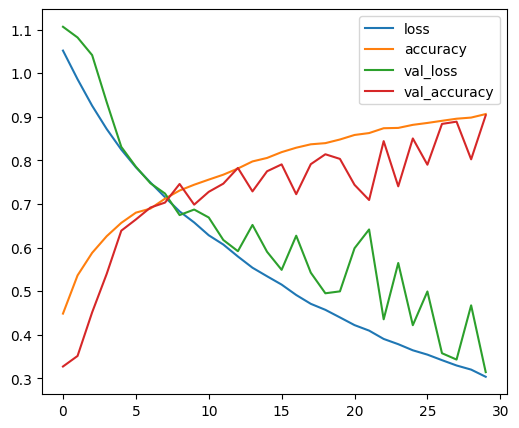

[[1244   54   27]
 [ 115 1214   62]
 [  76   58 1201]]


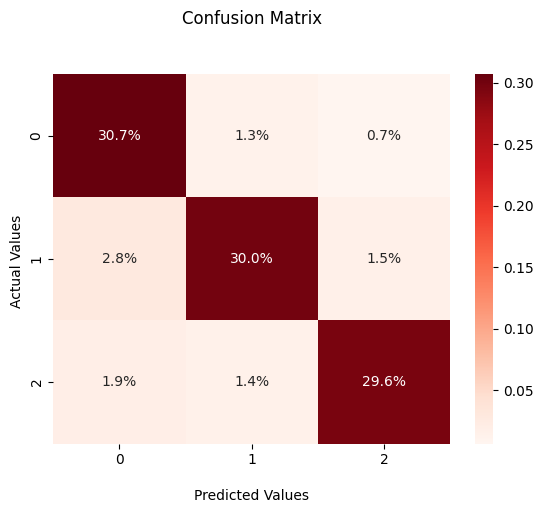

COMPILING...
32/32 [==============================] - 1s 15ms/step - loss: 0.3742 - accuracy: 0.8492
Score : loss of 0.37415701150894165; accuracy of 84.91730690002441%
127/127 [==============================] - 1s 5ms/step
F1 score:  0.846338862661547
Precision:  0.8600019857335346
Recall:  0.8491730436929154


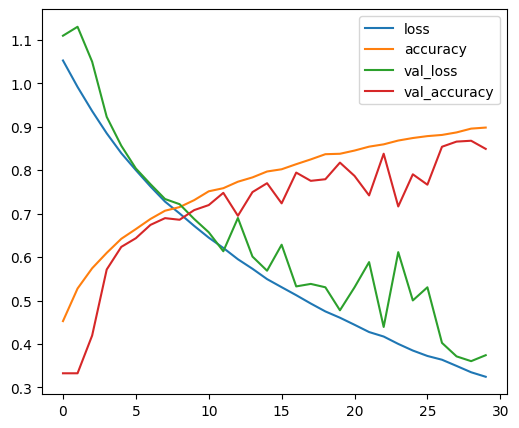

[[1273   27   47]
 [ 216  956  193]
 [  94   34 1211]]


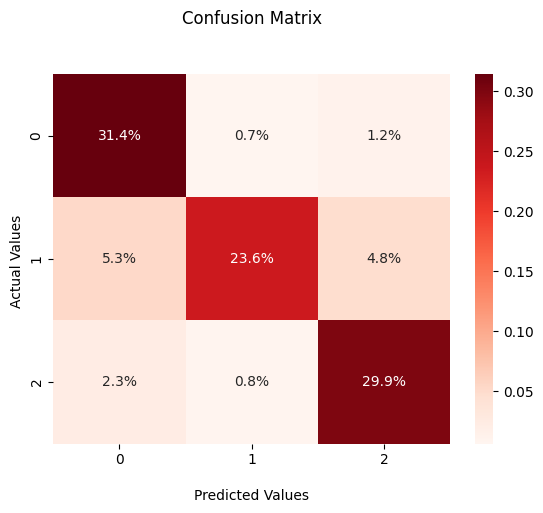

COMPILING...
32/32 [==============================] - 1s 15ms/step - loss: 0.3508 - accuracy: 0.8768
Score : loss of 0.350779265165329; accuracy of 87.68205642700195%
127/127 [==============================] - 1s 6ms/step
F1 score:  0.8763350797721632
Precision:  0.8829392974539874
Recall:  0.8768205381387312


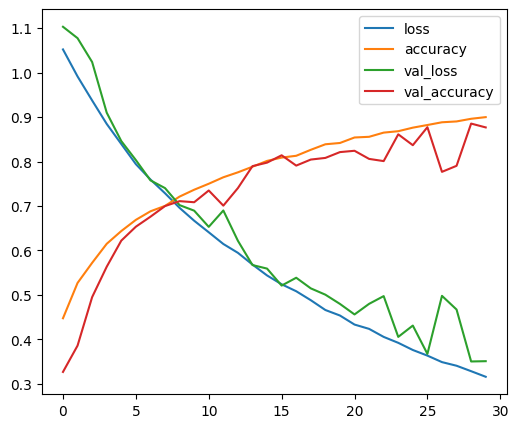

[[1051  163  109]
 [  35 1261  121]
 [  13   58 1240]]


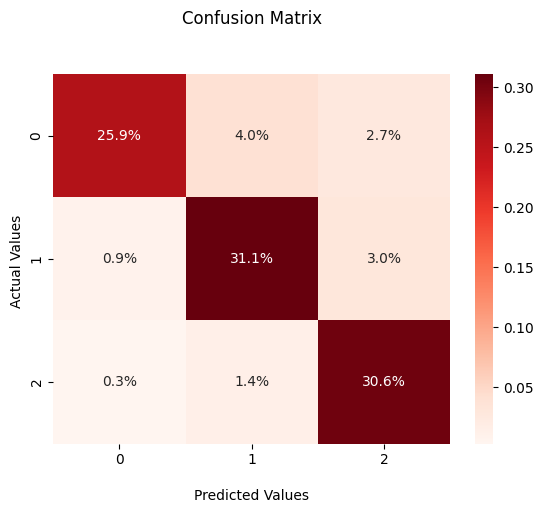

COMPILING...
32/32 [==============================] - 1s 15ms/step - loss: 0.3974 - accuracy: 0.8410
Score : loss of 0.3973979353904724; accuracy of 84.09876823425293%
127/127 [==============================] - 1s 5ms/step
F1 score:  0.8367354391396645
Precision:  0.8634469453036514
Recall:  0.8409876543209877


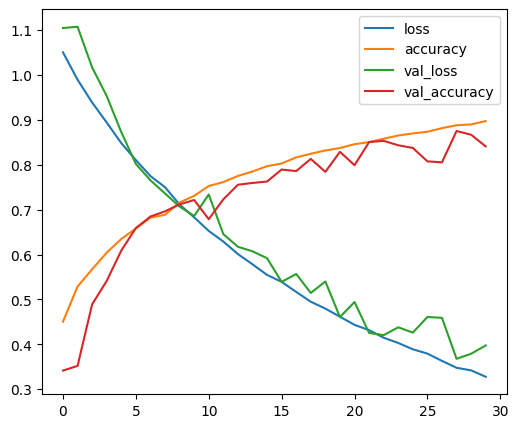

[[1267   16  100]
 [ 149  869  332]
 [  33   14 1270]]


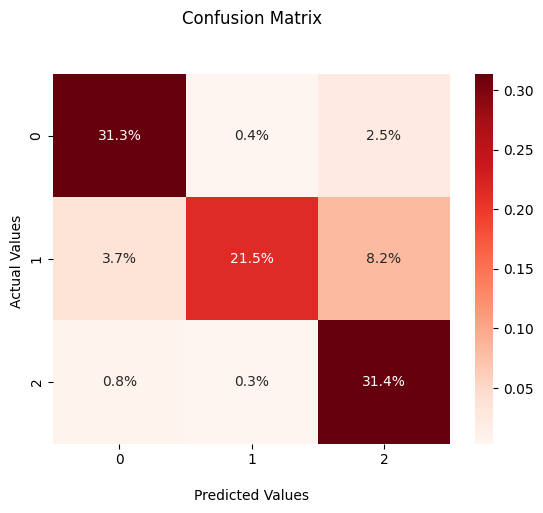

COMPILING...
32/32 [==============================] - 1s 15ms/step - loss: 0.4922 - accuracy: 0.7825
Score : loss of 0.4921605885028839; accuracy of 78.24691534042358%
127/127 [==============================] - 1s 5ms/step
F1 score:  0.7811332002582478
Precision:  0.8294717573130765
Recall:  0.7824691358024691


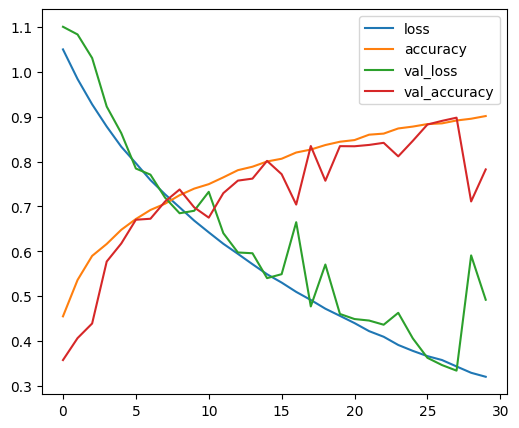

[[ 848  149  380]
 [  22 1044  300]
 [   3   27 1277]]


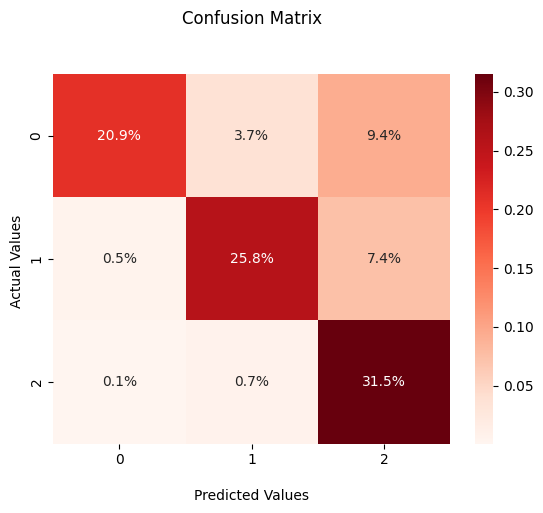

In [ ]:
X = {}
y = {}

X["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data))])
X["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data))])
X["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data))])
X["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data))])
X["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data))])
X["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data))])

y = np.concatenate([all_data[i]["label"] for i in range(len(all_data))])

fcn(X, y, 5)

In [ ]:
all_scores_fcn

[0.9032337665557861,
 0.8491730690002441,
 0.8768205642700195,
 0.8409876823425293,
 0.7824691534042358]

In [ ]:
all_f1_fcn

[0.903246586888324,
 0.846338862661547,
 0.8763350797721632,
 0.8367354391396645,
 0.7811332002582478]

In [ ]:
np.mean(all_scores_fcn)

0.850536847114563

In [ ]:
np.mean(all_f1_fcn)

0.8487578337439892

**ResNet Results**

INSIDE CLASSIFIER
COMPILING...
32/32 [==============================] - 1s 42ms/step - loss: 0.0478 - accuracy: 0.9936
Score : loss of 0.047815725207328796; accuracy of 99.35818314552307%
127/127 [==============================] - 4s 16ms/step
F1 score:  0.9935752268522359
Precision:  0.9936381906774926
Recall:  0.993581831646507


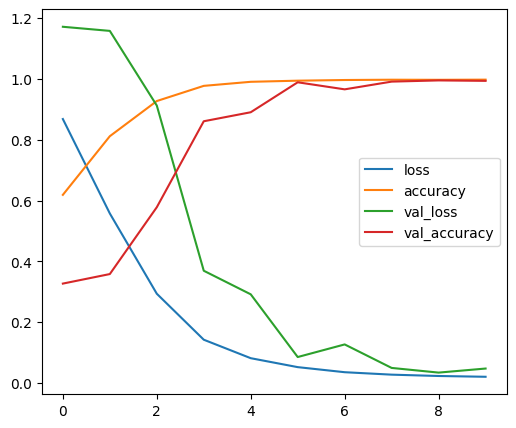

[[1303   15    7]
 [   0 1389    2]
 [   0    2 1333]]


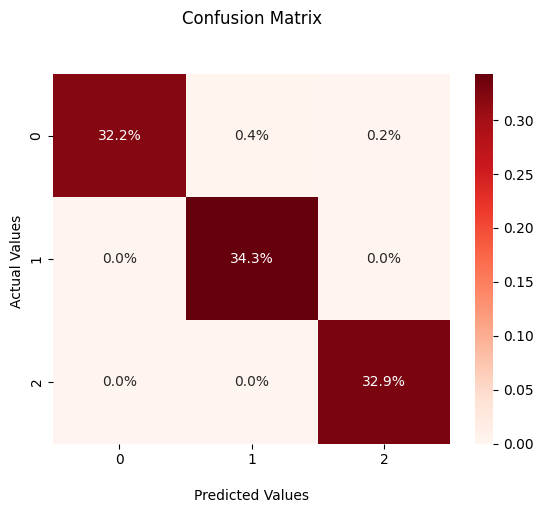

COMPILING...
32/32 [==============================] - 1s 43ms/step - loss: 0.1603 - accuracy: 0.9445
Score : loss of 0.1603187769651413; accuracy of 94.44581866264343%
127/127 [==============================] - 4s 16ms/step
F1 score:  0.9434522346168436
Precision:  0.9496067637409487
Recall:  0.9444581584793879


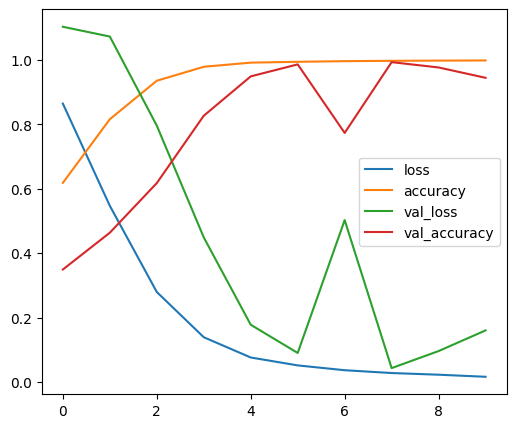

[[1128  169   50]
 [   0 1362    3]
 [   0    3 1336]]


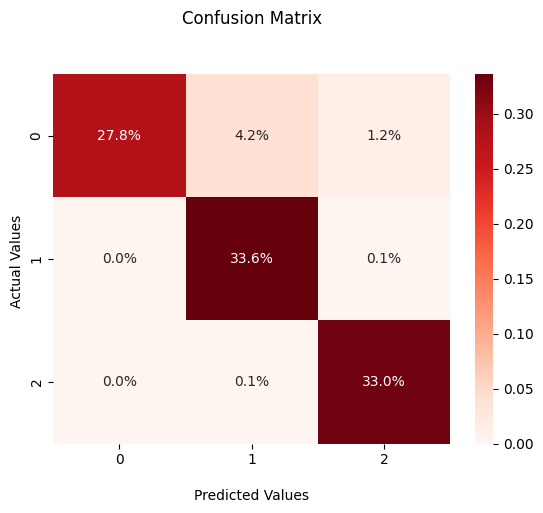

COMPILING...
32/32 [==============================] - 1s 43ms/step - loss: 0.0434 - accuracy: 0.9943
Score : loss of 0.04344264790415764; accuracy of 99.4322419166565%
127/127 [==============================] - 4s 16ms/step
F1 score:  0.9943241973140966
Precision:  0.9943309667358439
Recall:  0.9943223895334485


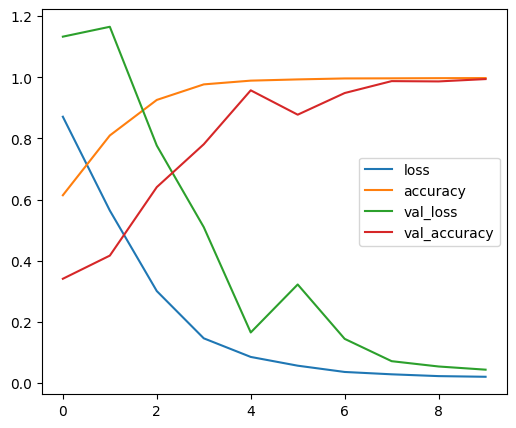

[[1312   11    0]
 [   6 1409    2]
 [   1    3 1307]]


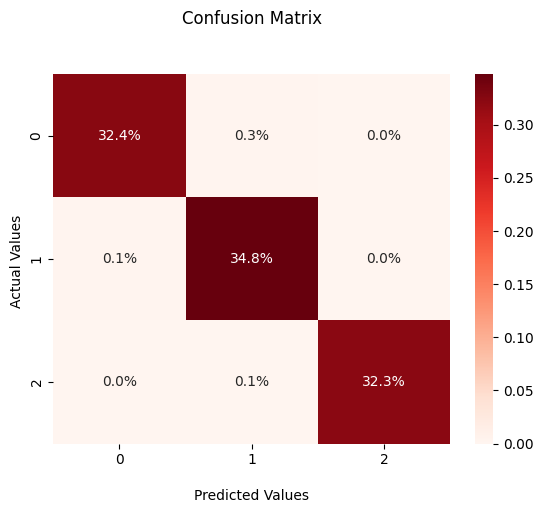

COMPILING...
32/32 [==============================] - 1s 44ms/step - loss: 0.1201 - accuracy: 0.9573
Score : loss of 0.12012912333011627; accuracy of 95.72839736938477%
127/127 [==============================] - 4s 17ms/step
F1 score:  0.9578263945301762
Precision:  0.9620963164536238
Recall:  0.9575308641975309


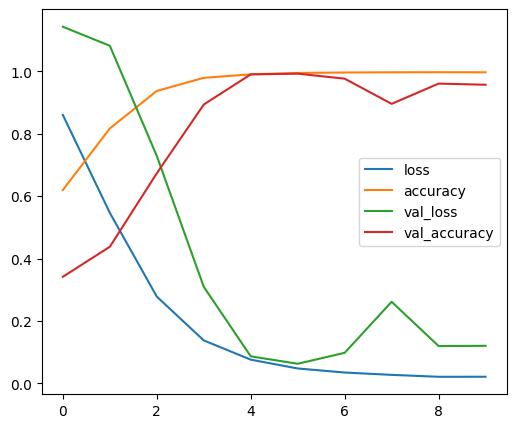

[[1248  131    4]
 [   0 1350    0]
 [   0   37 1280]]


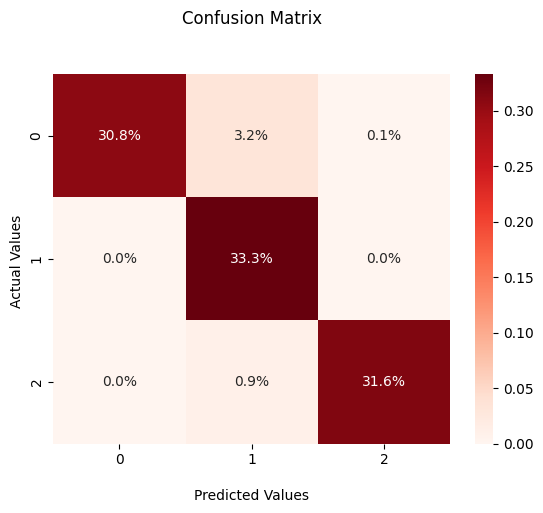

COMPILING...
32/32 [==============================] - 1s 43ms/step - loss: 0.3548 - accuracy: 0.8630
Score : loss of 0.35478103160858154; accuracy of 86.29629611968994%
127/127 [==============================] - 4s 15ms/step
F1 score:  0.8617452436909978
Precision:  0.8999082422757029
Recall:  0.8629629629629629


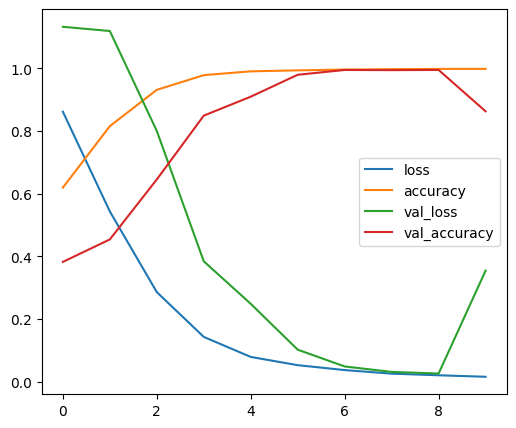

[[1292    0   85]
 [  24  899  443]
 [   2    1 1304]]


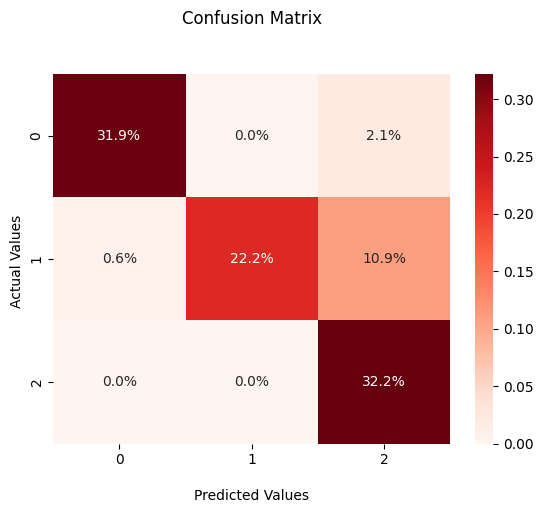

In [ ]:
X = {}
y = {}

X["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data))])
X["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data))])
X["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data))])
X["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data))])
X["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data))])
X["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data))])

y = np.concatenate([all_data[i]["label"] for i in range(len(all_data))])
ResNet(X, y, 5)

In [ ]:
all_scores_res

[0.9935818314552307,
 0.9444581866264343,
 0.9943224191665649,
 0.9572839736938477,
 0.8629629611968994]

In [ ]:
np.mean(all_scores_res)

0.9505218744277955

In [ ]:
all_f1_res

[0.9935752268522359,
 0.9434522346168436,
 0.9943241973140966,
 0.9578263945301762,
 0.8617452436909978]

In [ ]:
np.mean(all_f1_res)

0.95018465940087